<a href="https://colab.research.google.com/github/IlyaZutler/Project_2-Trucks/blob/main/DM%20_%20Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic mitochondria Project - Heavy Machinery Auction Price Estimator

> https://www.kaggle.com/t/9baafb8850d74e4499c7b1ba97d6f115

### Timeline
- **Start Date:** [Start Date]
- **End Date:** 14/07/2024 (11 days to go)

### 2. Exploratory Data Analysis (EDA)

Conduct EDA to understand the dataset and identify any data quality issues. Look for missing values, outliers, and relationships between features and the target variable.

### 3. Data Preprocessing

- Handle missing values appropriately.
- Encode categorical variables.
- Normalize or standardize numerical features if necessary.

### 6. Model Improvement

- Handle missing values and categorical variables more effectively.
- Use feature importances to identify key features.
- Perform feature engineering to create new informative features.
- Tune hyperparameters using grid search or other techniques.
- Monitor for overfitting by comparing training and testing performance.


## Practical Data Science Guidelines

- **Efficient Workflows:** Use a random subset of 20,000 rows for initial experiments. Use the full dataset for the final submission.
- **Iterative Approach:** Start with a basic model and iteratively improve it by trying small ideas.
- **Feature Engineering:** Transform and combine existing features creatively.
- **Documentation:** Keep track of your experiments and results. Document what works and what doesn't.

## Collaboration and Presentation

- **Collaboration:** Discuss your work openly within your team or with other teams. Sharing insights and learning from each other is encouraged.
- **Presentation:** Present your methodology, results, and the techniques that helped the most. Document your journey and the steps you took to achieve your results



In [1]:
import gdown
from pathlib import Path

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [2]:
def download_from_gdrive(url, filename):
    # Extract the file ID from the URL
    file_id = url.split('/')[-2]
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Download the file
    if Path(filename).exists():
        print(f"File '{filename}' already exists. Skipping download.")
    else:
        gdown.download(download_url, filename, quiet=False)
        print(f"File downloaded as: {filename}")

train = 'https://drive.google.com/file/d/1guqSpDv1Q7ZZjSbXMYGbrTvGns0VCyU5/view?usp=drive_link'
valid = 'https://drive.google.com/file/d/1j7x8xhMimKbvW62D-XeDfuRyj9ia636q/view?usp=drive_link'
# Example usage

download_from_gdrive(train, 'train.csv')
download_from_gdrive(valid, 'valid.csv')

df = pd.read_csv('train.csv')
df_valid = pd.read_csv('valid.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1guqSpDv1Q7ZZjSbXMYGbrTvGns0VCyU5
From (redirected): https://drive.google.com/uc?id=1guqSpDv1Q7ZZjSbXMYGbrTvGns0VCyU5&confirm=t&uuid=37ec927c-6a05-453b-bd42-98f1756444d4
To: /content/train.csv
100%|██████████| 116M/116M [00:01<00:00, 83.4MB/s]


File downloaded as: train.csv


Downloading...
From: https://drive.google.com/uc?id=1j7x8xhMimKbvW62D-XeDfuRyj9ia636q
To: /content/valid.csv
100%|██████████| 3.32M/3.32M [00:00<00:00, 73.5MB/s]


File downloaded as: valid.csv


<ipython-input-2-861d4f7287ed>:20: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')


## Exploratory Data Analysis (EDA)

In [ ]:
#df.fiProductClassDesc.value_counts()

In [ ]:
#df.info()

In [ ]:
 #df.SalesID.nunique()

In [ ]:
# df.isnull().sum()

In [ ]:
#df.describe()

In [ ]:
#sns.histplot(data=df, x='SalePrice', bins=20)

In [ ]:
# to see value_counts for all categorical columns, but some realy categorical columns has numerical type like ModelID
categorical_cols = df.select_dtypes(exclude='number').columns
for col in categorical_cols:
  print(f"Value counts for column '{col}':")
  print(df[col].value_counts())
  print(f"NaN values:{df[col].isnull().sum()}")
  print()

### 3. Data Preprocessing

In [ ]:
#df['Transmission'] = df['Transmission'].replace('AutoShift', 'Autoshift')
def fix_mistakes(X, replacement_dict):

    for col, replacements in replacement_dict.items():
        X[col] = X[col].replace(replacements)
    return X

fix_mistakes(df, replacement_dict = {'Transmission': {'AutoShift': 'Autoshift'}})
fix_mistakes(df_valid, replacement_dict = {'Transmission': {'AutoShift': 'Autoshift'}})

In [4]:
def fix_data(X, date_col):
    for col in date_col:
        X[col] = pd.to_datetime(X[col])
        X[col + '_Year'] = X[col].dt.year
        X[col + '_Month'] = X[col].dt.month
        X = X.drop(col, axis=1)
    return X

df = fix_data(df, date_col = ['saledate'])
df_valid = fix_data(df_valid, date_col = ['saledate'])

In [ ]:
def first_word_name(X, col):
    for col_ in col:
        X[col_+'_first_word'] = X[col_].apply(lambda x: x.split()[0] if isinstance(x, str) else x)
    return X

first_word_name(df, col = ['fiProductClassDesc'])
first_word_name(df_valid, col = ['fiProductClassDesc'])

In [6]:
def ord_enc_nan(X, col, categories):
    encoder = OrdinalEncoder(categories=[categories], handle_unknown='use_encoded_value', unknown_value= -1)
    X[col + '_3'] = encoder.fit_transform(X[[col]])
    counts = list(range(len(categories)))
    mean_real = X[col + '_3'][X[col + '_3'].isin(counts)].mean()
    X[col + '_3'] = X[col + '_3'].replace(-1, mean_real)
    X[col + '_3'] = X[col + '_3'].fillna(mean_real)
    return X
df = ord_enc_nan(df, col = 'UsageBand', categories = ['Low', 'Medium', 'High'])
df_valid = ord_enc_nan(df_valid, col = 'UsageBand', categories = ['Low', 'Medium', 'High'])

df = ord_enc_nan(df, col = 'ProductSize', categories = ['Mini', 'Compact', 'Small', 'Medium', 'Large / Medium', 'Large', 'High'])
df_valid = ord_enc_nan(df_valid, col = 'ProductSize', categories = ['Mini', 'Compact', 'Small', 'Medium', 'Large / Medium', 'Large', 'High'])


In [ ]:
# processing of categorical ordinal features - using libruary Sklern OrdinalEncoder
# encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High']], handle_unknown='use_encoded_value', unknown_value= -1) # Handle unknown values
# df['UsageBand_3'] = encoder.fit_transform(df[['UsageBand']])
# mean_real = df['UsageBand_3'][df.UsageBand_3.isin([0,1,2])].mean()
# df['UsageBand_3'] = df['UsageBand_3'].replace(-1, mean_real)
# # Fix: Fill missing values in the 'UsageBand_3' column and keep it in the DataFrame
# df['UsageBand_3'] = df['UsageBand_3'].fillna(mean_real)
# df['UsageBand_3'].value_counts(), df['UsageBand_3'].isnull().sum()


In [ ]:
# 'Undercarriage_Pad_Width' - remove ' inch' from data - to numeric
# df['Undercarriage_Pad_Width_3'] = df['Undercarriage_Pad_Width'].str.replace(' inch', '').replace('None or Unspecified', -1)
# df['Undercarriage_Pad_Width_3'] = pd.to_numeric(df['Undercarriage_Pad_Width_3'])
# mean_real_2 = df['Undercarriage_Pad_Width_3'][df.Undercarriage_Pad_Width_3 != -1].mean()
# df['Undercarriage_Pad_Width_3'] = df['Undercarriage_Pad_Width_3'].replace(-1, mean_real_2)
# df['Undercarriage_Pad_Width_3'] = df['Undercarriage_Pad_Width_3'].fillna(mean_real_2)
# df['Undercarriage_Pad_Width_3'].value_counts(),df['Undercarriage_Pad_Width_3'].isnull().sum()

In [ ]:
# 'Stick_Length' - remove " from data - to numeric
# df['Stick_Length_3'] = df['Stick_Length'].str.replace("' ", '.').str.replace('"', '').replace('None or Unspecified', -1)
# df['Stick_Length_3'] = pd.to_numeric(df['Stick_Length_3'])
# mean_real_3 = df['Stick_Length_3'][df.Stick_Length_3.isna() | df.Stick_Length_3 != -1 ].mean()
# print(mean_real_3)
# df['Stick_Length_3'] = df['Stick_Length_3'].replace(-1, mean_real_3)
# df['Stick_Length_3'] = df['Stick_Length_3'].fillna(mean_real_3)
# df['Stick_Length_3'].value_counts(), df['Stick_Length_3'].isnull().sum()

In [ ]:
#df[df['YearMade'] == 1000].head(20) # i have not idias what to do with year 1000

## Mean / Target coding

In [ ]:
df['datasource'] = df['datasource'].astype('object')
df_valid['datasource'] = df_valid['datasource'].astype('object')

In [ ]:
def make_target_mean_dict(X, target_col):
    target_mean_dict = {}
    target_nan_mean_dict = {}

    for col in df.select_dtypes(exclude='number').columns:
        target_mean_dict[col] = X.groupby(col)[target_col].mean().to_dict()
        target_nan_mean_dict[col] = X[df[col].isna()][target_col].mean()

    return target_mean_dict, target_nan_mean_dict


target_mean_dict, target_nan_mean_dict = make_target_mean_dict(df, target_col = 'SalePrice')


def target_encode(X, target_mean_dict, target_nan_mean_dict):
    for col in X.select_dtypes(exclude='number').columns:
        X[col + '_2'] = X[col].map(target_mean_dict[col]).fillna(target_nan_mean_dict[col])
        X[col + '_2'] = X[col + '_2'].astype(float)
    return X

df = target_encode(df, target_mean_dict, target_nan_mean_dict)
df_valid = target_encode(df_valid, target_mean_dict, target_nan_mean_dict)

In [ ]:
df.head(1)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saledate_Year,saledate_Month,fiProductClassDesc_first_word,datasource_2,UsageBand_2,fiModelDesc_2,fiBaseModel_2,fiSecondaryDesc_2,fiModelSeries_2,fiModelDescriptor_2,ProductSize_2,fiProductClassDesc_2,state_2,ProductGroup_2,ProductGroupDesc_2,Drive_System_2,Enclosure_2,Forks_2,Pad_Type_2,Ride_Control_2,Stick_2,Transmission_2,Turbocharged_2,Blade_Extension_2,Blade_Width_2,Enclosure_Type_2,Engine_Horsepower_2,Hydraulics_2,Pushblock_2,Ripper_2,Scarifier_2,Tip_Control_2,Tire_Size_2,Coupler_2,Coupler_System_2,Grouser_Tracks_2,Hydraulics_Flow_2,Track_Type_2,Undercarriage_Pad_Width_2,Stick_Length_2,Thumb_2,Pattern_Changer_2,Grouser_Type_2,Backhoe_Mounting_2,Blade_Type_2,Travel_Controls_2,Differential_Type_2,Steering_Controls_2,fiProductClassDesc_first_word_2
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,Wheel,33847.429543,28334.13044,46081.730769,47209.558824,29402.883487,29981.26601,27685.564519,23979.399753,36185.68684,35369.592778,37052.463249,37052.463249,32431.888757,51777.326782,23512.603724,33608.04452,34754.662273,33608.04452,31016.734588,33608.04452,30002.690135,30002.690135,30002.690135,30002.690135,35997.1916,30002.690135,28322.244623,30002.8219,30002.690135,35109.295712,30256.342249,33596.706467,33591.153814,33591.153814,29565.657382,29570.555118,29565.690564,29565.729818,29565.690564,29565.657382,29816.728063,29831.619645,29832.178505,36854.326664,36975.240306,37052.463249


In [ ]:
df_valid.head(1)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saledate_Year,saledate_Month,fiProductClassDesc_first_word,datasource_2,UsageBand_2,fiModelDesc_2,fiBaseModel_2,fiSecondaryDesc_2,fiModelSeries_2,fiModelDescriptor_2,ProductSize_2,fiProductClassDesc_2,state_2,ProductGroup_2,ProductGroupDesc_2,Drive_System_2,Enclosure_2,Forks_2,Pad_Type_2,Ride_Control_2,Stick_2,Transmission_2,Turbocharged_2,Blade_Extension_2,Blade_Width_2,Enclosure_Type_2,Engine_Horsepower_2,Hydraulics_2,Pushblock_2,Ripper_2,Scarifier_2,Tip_Control_2,Tire_Size_2,Coupler_2,Coupler_System_2,Grouser_Tracks_2,Hydraulics_Flow_2,Track_Type_2,Undercarriage_Pad_Width_2,Stick_Length_2,Thumb_2,Pattern_Changer_2,Grouser_Type_2,Backhoe_Mounting_2,Blade_Type_2,Travel_Controls_2,Differential_Type_2,Steering_Controls_2,fiProductClassDesc_first_word_2
0,1222837,902859,1376,121,3,1000,0.0,NaN,375L,375,NaN,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 66.0 to 90.0 Metr...",Kentucky,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2012,1,Hydraulic,33847.429543,30209.249944,73613.924051,72683.823529,23397.791284,29981.26601,57795.308661,47719.945952,61059.626437,29918.207654,35666.120622,35666.120622,32431.888757,28745.229806,37194.246441,33608.04452,32613.419521,33608.04452,31016.734588,33608.04452,30002.690135,30002.690135,30002.690135,30002.690135,29274.054097,30002.690135,28322.244623,30002.8219,30002.690135,28361.684325,30256.342249,33596.706467,33591.153814,33591.153814,39139.034413,34875.912117,32389.146473,35165.33365,34148.327361,34607.979753,29816.728063,29831.619645,29832.178505,29815.001137,29814.778141,35666.120622


# Select data for model

In [ ]:
df2 = df.select_dtypes('number')
X_valid = df_valid.select_dtypes('number')

y = df2['SalePrice']
X = df2.drop(columns=['SalePrice', 'MachineID', 'ModelID', 'SalesID'])
X_valid2 = X_valid.drop(columns=['MachineID', 'ModelID', 'SalesID'])

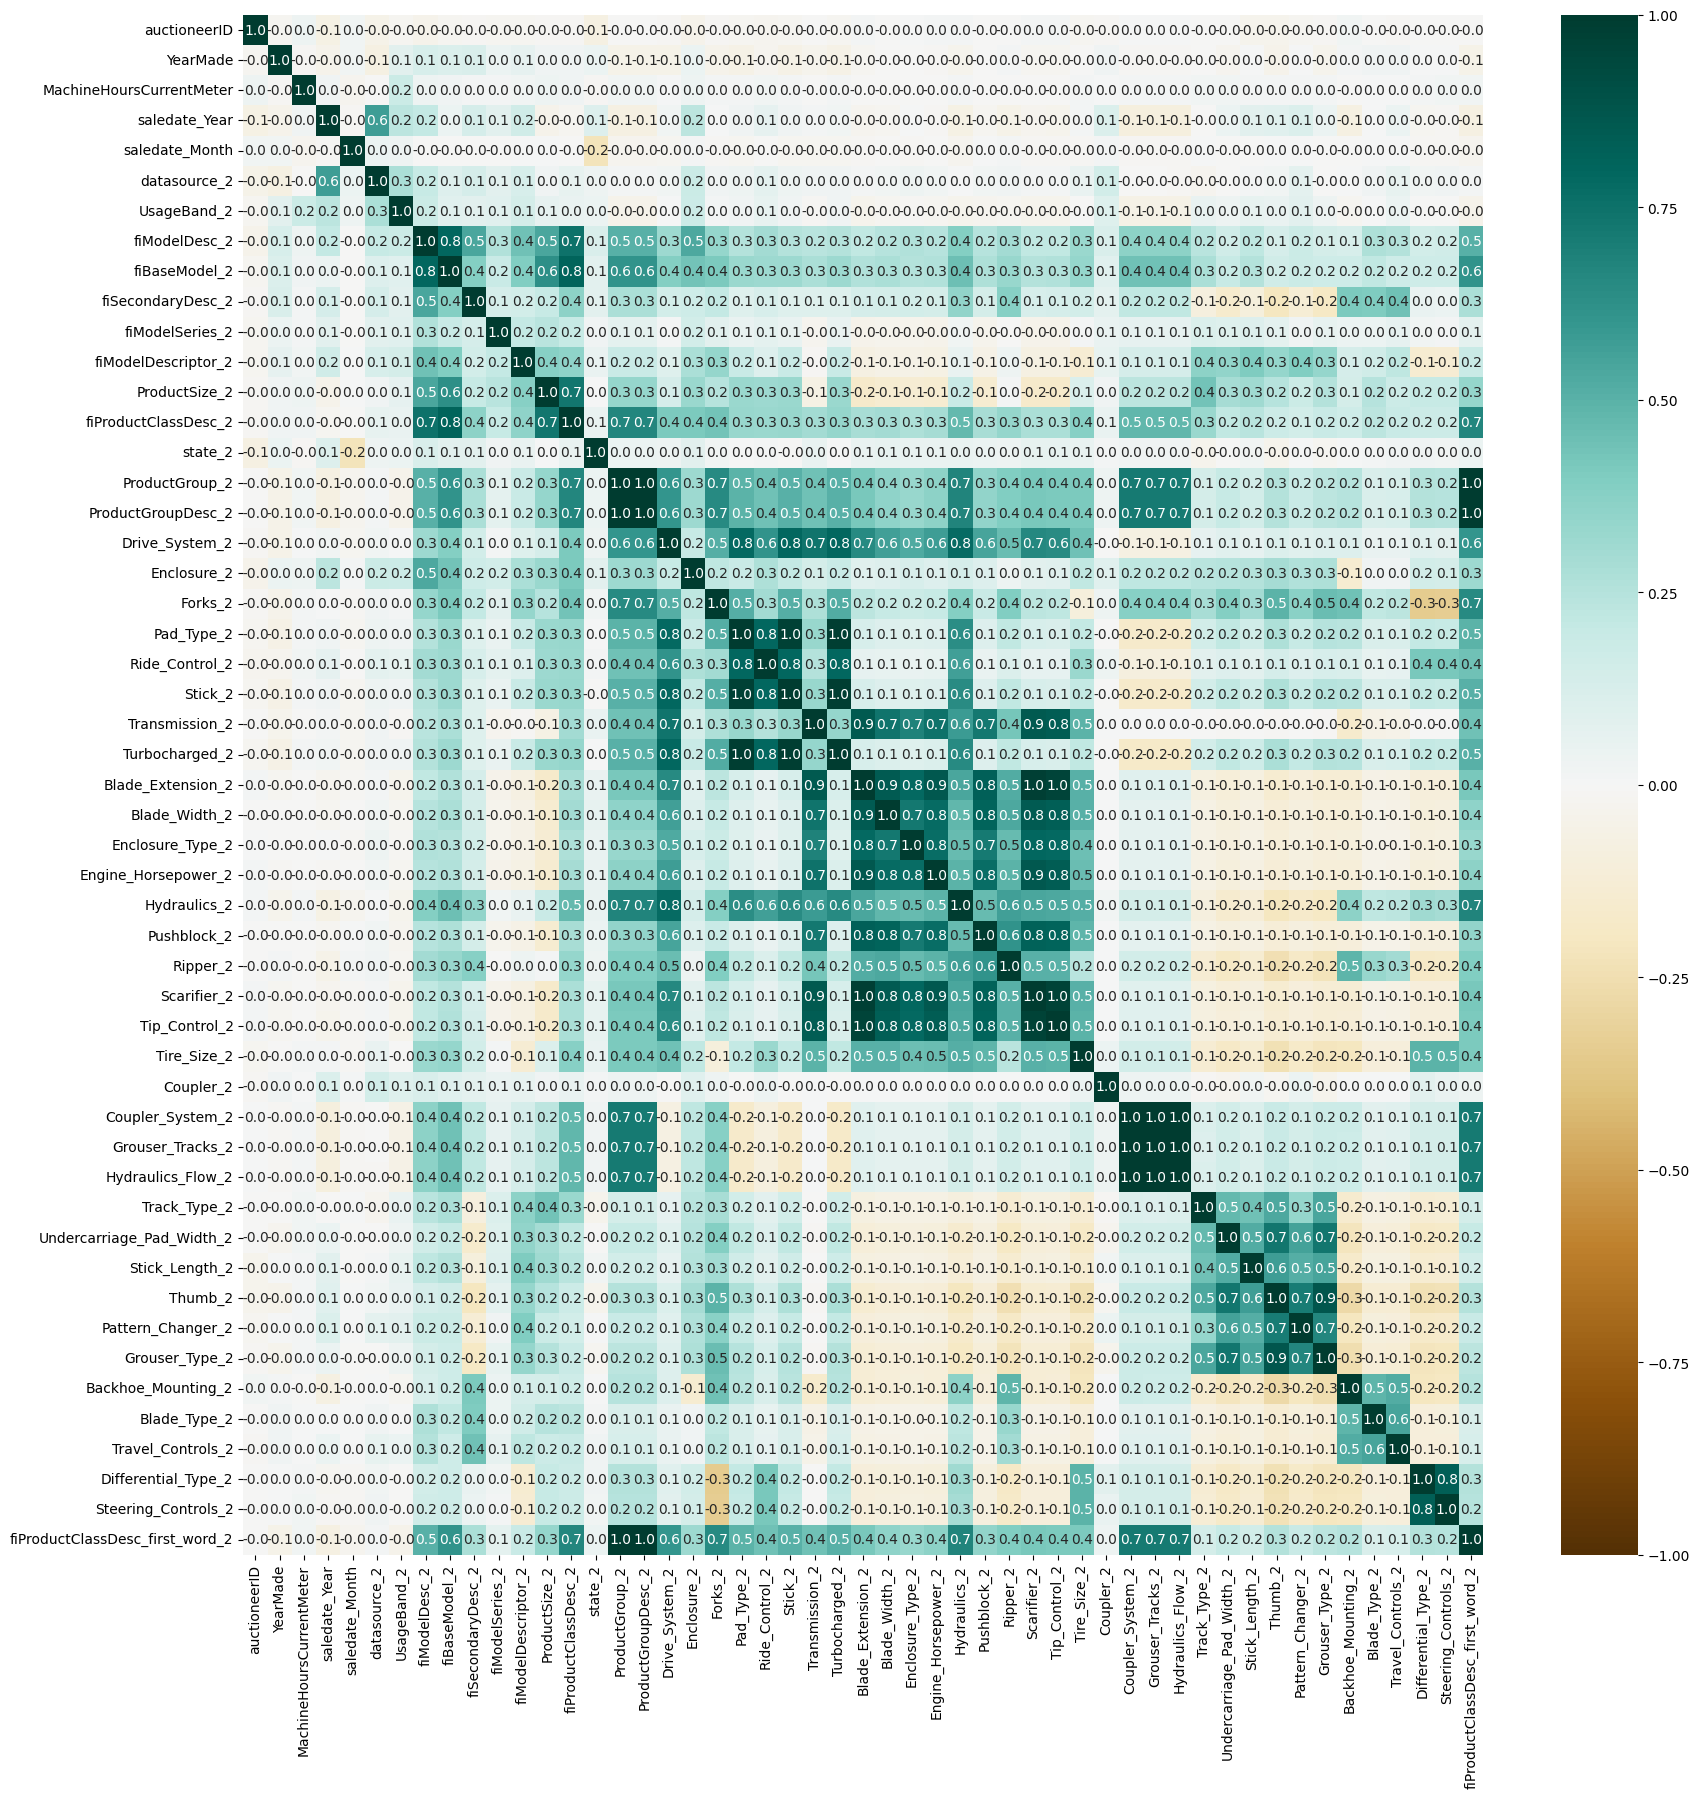

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(X.corr(), vmin=-1, fmt=".1f", vmax=1, annot=True, cmap='BrBG')
plt.show()


In [ ]:
X_train = X #.sample((len(X), random_state=42)
y_train = y #.loc[X_train.index]

#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# scaler = MinMaxScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
# X_valid2 = pd.DataFrame(scaler.transform(X_valid2), columns=X_valid2.columns, index=X_valid2.index)

X_train = X_train.fillna(X_train.mean())
#X_test = X_test.fillna(X_train.mean())
X_valid2 = X_valid2.fillna(X_train.mean())

In [ ]:
%%time
model = RandomForestRegressor(n_jobs=-1,
                              n_estimators = 700,
                              #max_depth = 10,
                              min_impurity_decrease = 10,
                              random_state = 42,
                              max_features = 'sqrt',
                              #max_samples=0.75
                              )

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
#y_test_pred = model.predict(X_test)

y_valid_pred = model.predict(X_valid2)

print(f'Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
#print(f'Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
#print(f'R²:' , r2_score(y_test, y_test_pred))
print(f'Train MAE:', mean_absolute_error(y_train, y_train_pred))
#print(f'Test MAE:', mean_absolute_error(y_test, y_test_pred))


Train RMSE: 3791.6000972295774
Train MAE: 2576.7964623446896
CPU times: user 14min 11s, sys: 8.82 s, total: 14min 20s
Wall time: 8min 43s


In [ ]:
### Feature importance
pd.Series(
    model.feature_importances_,
    index=model.feature_names_in_
).sort_values(ascending=False)

fiModelDesc_2                      0.292358
fiBaseModel_2                      0.104009
fiProductClassDesc_2               0.083600
YearMade                           0.083561
saledate_Year                      0.059312
Enclosure_2                        0.053806
fiSecondaryDesc_2                  0.050498
ProductSize_2                      0.033550
state_2                            0.018536
fiModelDescriptor_2                0.017398
fiProductClassDesc_first_word_2    0.017108
saledate_Month                     0.016775
ProductGroupDesc_2                 0.016284
ProductGroup_2                     0.014976
MachineHoursCurrentMeter           0.012377
auctioneerID                       0.011468
datasource_2                       0.008987
Ripper_2                           0.007140
Hydraulics_2                       0.006955
fiModelSeries_2                    0.006494
Tire_Size_2                        0.005989
Blade_Type_2                       0.005690
Coupler_System_2                

In [ ]:
# Create a submission file
submission = pd.DataFrame({'SalesID': X_valid['SalesID'], 'SalePrice': y_valid_pred})
submission.to_csv('final_submission.csv', index=False)